In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compare

## Functions Needed

In [76]:
def leave_users_out(full_data, leave_out, seed=1234):
    np.random.seed(seed)
    full_data['index'] = full_data.index
    user_index_df = full_data.groupby('user')['index'].apply(list)
    users = np.random.choice(list(user_index_df.index), leave_out, replace=False)
    users_indices = []
    
    for user in users:
        users_indices.extend(user_index_df.loc[user])
    
    sub_set = full_data.loc[users_indices]
    remaining = full_data.drop(users_indices)
    
    return remaining.drop(columns=['index']), sub_set.drop(columns=['index'])

In [77]:
def leave_last_x_out(full_data, n_users, leave_out=1, seed=1234):
    # Input: data must contain user_id
    # Output: full_data = without all last (time order) entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    np.random.seed(seed)
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    users = full_data.user_id.unique()
    leave_out_indices = []
    users_picked = []
    
    for i in range(n_users):
        random_user = np.random.choice(users)
        item_indices = user_items_ind[random_user] # random user's items indices
        while random_user not in users_picked and len(item_indices) <= leave_out: # needs to have more items than to leave out, or deleting users
            random_user = np.random.choice(users)
            item_indices = user_items_ind[random_user]
            
        users_picked.append(random_user)
        leave_out_indices.extend(item_indices[-leave_out:])
    
    leave_out_set = full_data.loc[leave_out_indices] # the last items of n_users users with n_item > leave_out
    full_data_leave_one_out = full_data.drop(leave_out_indices) # drops last items for n_users users
    
    return full_data_leave_one_out.drop(columns=['index']), leave_out_set.drop(columns=['index'])

In [78]:
def create_train_test_split(df):
    BATCH_SIZE = 64

    df_og = df

    users_to_remove = len(df_og.user_id.unique())%BATCH_SIZE #Batch size compatible for CFRNN
    df, deleted_users = leave_users_out(df_og, users_to_remove)

    total_users = len(df_og.user_id.unique()) # Need all users for BPR
    total_items = len(df_og.item_id.unique()) # Need all items for CFRNN

    test_users = int(0.1*total_users) # Number of users to be used for testing
    test_last_items = 1 # Items to be removed from test users in train set and used in test set

    val_users = int(0.1*total_users) -1
    val_last_items = 1

    # Split
    train_set, test_set = leave_last_x_out(df, test_users, test_last_items)
    train_set, val_set = leave_last_x_out(train_set, val_users, val_last_items)
    
    return train_set, val_set, test_set

In [166]:
def print_stats(df):
    user_ratings = df.groupby('user')['rating'].count()
    item_ratings = df.groupby('item')['rating'].count()
    norpu = user_ratings.mean()
    norpi = item_ratings.mean()
    total_users = df.user.unique().size
    total_items = df.item.unique().size
    sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))
    
    train_set, val_set, test_set = create_train_test_split(df)
    
    print('rows ', len(df), 
          '\n#ratings/user', round(norpu,2), 
          '\n#ratings/item', round(norpi,2), 
          '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
          '\n#users ', df['user'].unique().size, 
          '\n#items ', df['item'].unique().size, 
          '\nsparse ', round(sparseness,5),
          '\nTrain users:', len(train_set.user_id.unique()),
          '\nVal users:', len(val_set.user_id.unique()),
          '\nTest users:', len(test_set.user_id.unique()))

In [173]:
def show_results(metrics, file_name, plot_title, legend_names, store=False, path=''):
    ranks_at = metrics[0]['rank_at']
    
    figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    figure.suptitle(plot_title)
    figure.subplots_adjust(wspace=0.4, hspace=0.4)
        
    bar_width = 1.0
    bar_dist = 1.0
    line_width = 2
    title_size = 'large'
    
    #Plots
    for i, m in enumerate(metrics):
        axes[0,0].plot(ranks_at, m['recall'], linewidth=line_width)
        axes[0,1].plot(ranks_at, m['precision'], linewidth=line_width)
        axes[1,0].bar(ranks_at[1:] + i*bar_dist, m['hitcounts'][1:], width=bar_width, align='center')
        axes[1,1].bar(ranks_at[0] + i*bar_dist, m['hitcounts'][0], width=bar_width, align='center')

    # Decoration
    ## Recall@1-20    
    for i, rank in enumerate(ranks_at):
        top = max([m['recall'][i] for m in metrics])
        axes[0,0].vlines(rank, 0, top, linestyle = '--', color='gainsboro', linewidth=line_width/2) 
    axes[0,0].set_title('Recall@1-20', fontsize=title_size)
    axes[0,0].set_xlabel('Rank@')
    axes[0,0].set_ylabel('Recall')
    
    ## Precision@1-20    
    for i, rank in enumerate(ranks_at):
        top = max([m['precision'][i] for m in metrics])
        axes[0,1].vlines(rank, 0, top, linestyle = '--', color='gainsboro', linewidth=line_width/2) 
    axes[0,1].set_title('Precision@1-20', fontsize=title_size)
    axes[0,1].set_xlabel('Rank@')
    axes[0,1].set_ylabel('Precision')
     
    ## Hitcounts@5-20
    axes[1,0].set_title('Hitcounts@5-20', fontsize=title_size)
    axes[1,0].set_xlabel('Rank@')
    axes[1,0].set_ylabel('Hitcounts')
    axes[1,0].set_xlim([1,24])
    axes[1,0].set_xticks(ranks_at[1:])
    
    ## Hitcounts@1
    axes[1,1].set_title('Hitcounts@1', fontsize=title_size)
    axes[1,1].set_xlabel('Rank@1')
    axes[1,1].set_ylabel('Hitcounts')
    axes[1,1].set_xticks([])
    
    figure.legend(legend_names, loc='lower center', ncol=4, fontsize='large')
    
    if store:
        figure.savefig(path + file_name + '_results')
    plt.show()

## Init

In [174]:
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
names_am = ['Amazon_01_users', 'Amazon_005_users']
names_ml = ['ML_01_users', 'ML_005_users']

res_path = path + 'Results/'
store_path = path + 'Plots/CFRNN_plots/'
file_names = names_am + names_ml
data_paths = ['Data/Amazon/']*len(names_am) + ['Data/ML/']*len(names_ml)

In [175]:
legend_names = ['CFRNN', 'BPR', 'Random', 'Popularity']

## Plot 

Amazon_01_users
rows  1058788 
#ratings/user 8.72 
#ratings/item 4.28 
average rating 4.28 
#users  121372 
#items  247465 
sparse  0.99996 
Train users: 121344 
Val users: 11545 
Test users: 11556


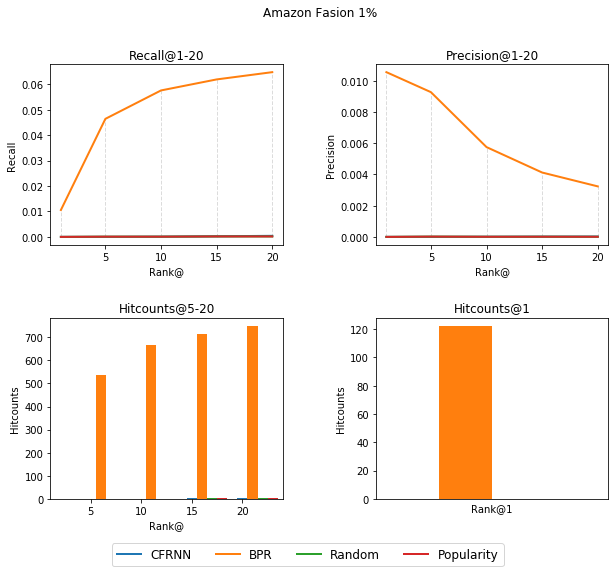


 

Amazon_005_users
rows  530686 
#ratings/user 8.74 
#ratings/item 3.01 
average rating 4.28 
#users  60686 
#items  176152 
sparse  0.99995 
Train users: 60672 
Val users: 5774 
Test users: 5774


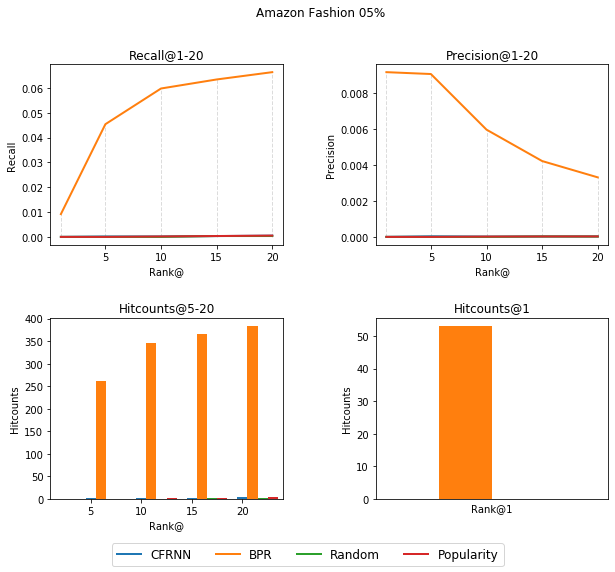


 

ML_01_users
rows  2446037 
#ratings/user 150.49 
#ratings/item 89.31 
average rating 3.55 
#users  16254 
#items  27387 
sparse  0.99451 
Train users: 16192 
Val users: 1549 
Test users: 1550


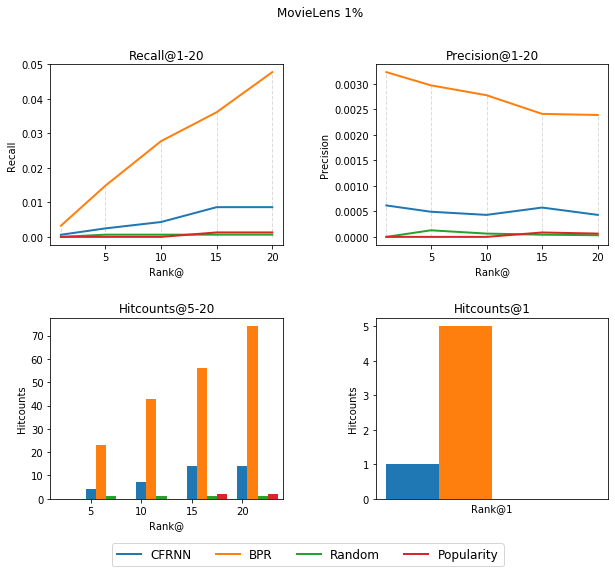


 

ML_005_users
rows  1226577 
#ratings/user 150.93 
#ratings/item 54.97 
average rating 3.55 
#users  8127 
#items  22312 
sparse  0.99324 
Train users: 8064 
Val users: 763 
Test users: 764


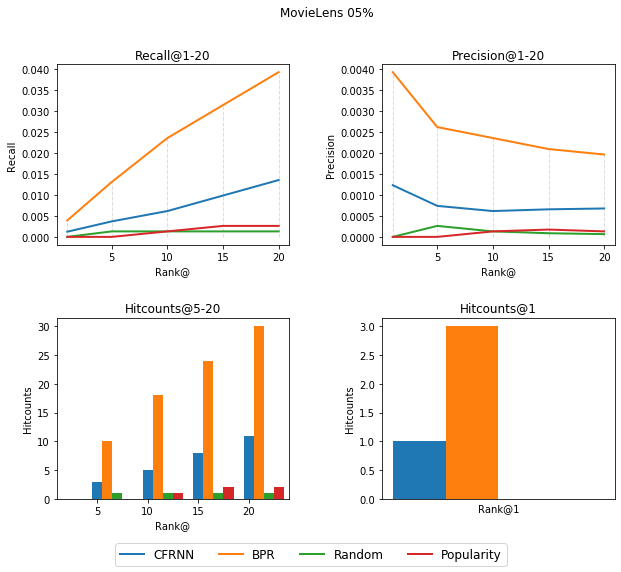

In [176]:
plot_titles = ['Amazon Fasion 1%', 'Amazon Fashion 05%', 'MovieLens 1%', 'MovieLens 05%']

for data_path, file_name, plot_title in zip(data_paths, file_names, plot_titles):
    print('='*100)
    print(file_name)
    df = pd.read_pickle(path + data_path + file_name)
    print_stats(df)
    
    cfrnn = pd.read_pickle(res_path + 'CFRNN/metrics_CFRNN_' + file_name) 
    bpr = pd.read_pickle(res_path + 'BPR/metrics_' + file_name)
    rand = pd.read_pickle(res_path + 'Benchmarks/rand_bench_' + file_name)
    pop = pd.read_pickle(res_path + 'Benchmarks/pop_bench_' + file_name)

    all_metrics = [cfrnn, bpr, rand, pop]
    
    show_results(all_metrics, file_name, plot_title, legend_names, store=True, path=store_path)
    print('='*100)
    print('\n','\n')

# Full data stats

In [144]:
path

'/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

In [147]:
df_amazon = pd.read_pickle(path + '/Data/Amazon/Amazon_full')

In [148]:
df_ml = pd.read_pickle(path + '/Data/ML/ML_full')

In [152]:
print_stats(df_amazon)

rows  10592657 
#ratings/user 8.73 
#ratings/item 28.22 
average rating 4.28 
#users  1213729 
#items  375397 
sparse  0.99998


In [153]:
print_stats(df_ml)

rows  25000095 
#ratings/user 153.81 
#ratings/item 423.39 
average rating 3.53 
#users  162541 
#items  59047 
sparse  0.9974
